This notebook takes the predictions made by the various models and calculates their performance.


In [2]:
import pandas as pd
from variables import PROJECTNAME_DATA_PATHS, SDG_MAP, ALL_EVAL_RESULTS_PATH
from file_org import iterdatatype_data
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def count_sdgs(data):
    sdg_counts = {k: 0 for k in SDG_MAP.keys()}
    total_rows = data.shape[0]

    for label_data in data["labels"]:
        for label in set(label_data):
            sdg_counts[label] += 1

    return sdg_counts, total_rows


all_results = []
for datatype in PROJECTNAME_DATA_PATHS.keys():
    for project_name, data in iterdatatype_data(datatype):
        sdg_counts, total_rows = count_sdgs(data)
        for sdg, sdg_count in sdg_counts.items():
            all_results.append(
                dict(
                    project_name=project_name,
                    sdg=sdg,
                    datatype=datatype,
                    total_rows=total_rows,
                    positive=sdg_count,
                    negative=total_rows - sdg_count,
                    pos_perc=sdg_count / total_rows,
                    neg_perc=(total_rows - sdg_count) / total_rows,
                )
            )

data_counts_df = pd.DataFrame(all_results)

model_performance = pd.read_json(ALL_EVAL_RESULTS_PATH, orient="records", lines=True)
data_counts_df = data_counts_df.merge(
    model_performance, how="left", on=["sdg", "project_name"]
)

data_counts_df.to_excel("../data/formatted_outputs/data_distribution.xlsx", index=False)
data_counts_df

,project_name,sdg,datatype_x,total_rows,positive,negative,pos_perc,neg_perc,model_name,datatype_y,precision,recall,f1,TP,FP,TN,FN
0,2023_all_ugrad_outlines,SDG 1,raw,2350,48,2302,0.020426,0.979574,logistic_regression,raw,0.866667,0.270833,0.412698,13,2,2300,35
1,2023_all_ugrad_outlines,SDG 1,raw,2350,48,2302,0.020426,0.979574,logistic_regression,test,NaN,0.000000,NaN,0,0,459,11
2,2023_all_ugrad_outlines,SDG 1,raw,2350,48,2302,0.020426,0.979574,uoft_dict_approach,raw,0.087649,0.458333,0.147157,22,229,2073,26
3,2023_all_ugrad_outlines,SDG 1,raw,2350,48,2302,0.020426,0.979574,uoft_dict_approach,test,0.103448,0.545455,0.173913,6,52,407,5
4,2023_all_ugrad_outlines,SDG 2,raw,2350,50,2300,0.021277,0.978723,logistic_regression,raw,NaN,0.000000,NaN,0,0,2300,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2023_undergrad_outlines,SDG 15,dev,96,4,92,0.041667,0.958333,uoft_dict_approach,test,0.000000,0.000000,NaN,0,12,83,1
956,2023_undergrad_outlines,SDG 16,dev,96,21,75,0.218750,0.781250,logistic_regression,raw,0.746667,0.500000,0.598930,56,19,346,56
957,2023_undergrad_outlines,SDG 16,dev,96,21,75,0.218750,0.781250,logistic_regression,test,0.650000,0.520000,0.577778,13,7,64,12
958,2023_undergrad_outlines,SDG 16,dev,96,21,75,0.218750,0.781250,uoft_dict_approach,raw,0.228889,0.919643,0.366548,103,347,18,9


# Graph the performance 

In [15]:
datatype = 'test'
project = '2023_all_ugrad_outlines'
SDG_ORDER = SDG_MAP.keys()

relevant_data = model_performance[(model_performance["datatype"] == datatype) & (model_performance["project_name"] == project)]
relevant_data.sort_values("f1").head()

,sdg,model_name,project_name,datatype,precision,recall,f1,TP,FP,TN,FN
181,SDG 9,logistic_regression,2023_all_ugrad_outlines,test,0.333333,0.034483,0.062500,1,2,439,28
55,SDG 13,uoft_dict_approach,2023_all_ugrad_outlines,test,0.034091,1.000000,0.065934,15,425,30,0
43,SDG 12,uoft_dict_approach,2023_all_ugrad_outlines,test,0.035635,1.000000,0.068817,16,433,21,0
67,SDG 14,uoft_dict_approach,2023_all_ugrad_outlines,test,0.045455,0.285714,0.078431,2,42,421,5
79,SDG 15,uoft_dict_approach,2023_all_ugrad_outlines,test,0.053140,0.687500,0.098655,11,196,258,5


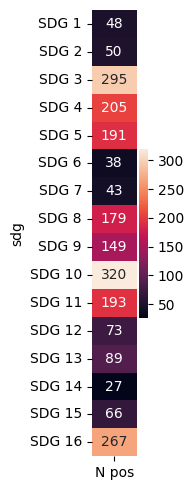

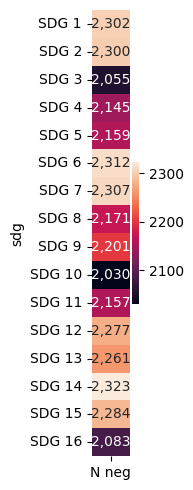

In [12]:
raw_data_counts = model_performance[(model_performance["datatype"] == "raw") & (model_performance["project_name"] == project)].drop_duplicates("sdg").set_index("sdg").reindex(SDG_ORDER)
raw_data_counts["N pos"] = raw_data_counts["TP"] + raw_data_counts["FN"]
raw_data_counts["N neg"] = raw_data_counts["FP"] + raw_data_counts["TN"]

plt.figure(figsize=(2,5))
sns.heatmap(raw_data_counts[["N pos"]], annot=True, fmt=",.0f")
plt.tight_layout()
plt.savefig("../data/presentation_figures/n_pos.png", dpi=300)
plt.show()
plt.figure(figsize=(2,5))
sns.heatmap(raw_data_counts[["N neg"]], annot=True, fmt=",.0f")
plt.tight_layout()
plt.savefig("../data/presentation_figures/n_neg.png", dpi=300)
plt.show()

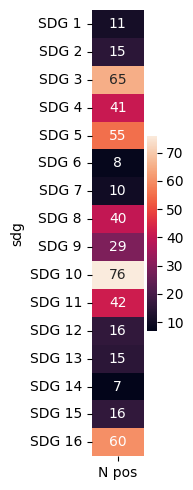

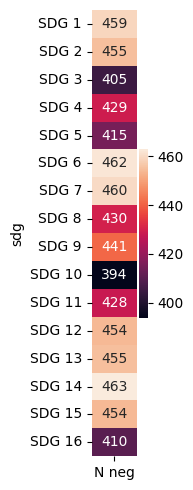

In [28]:
temp_reduced = relevant_data.drop_duplicates("sdg").set_index("sdg").reindex(SDG_ORDER)
temp_reduced["N pos"] = temp_reduced["TP"] + temp_reduced["FN"]
temp_reduced["N neg"] = temp_reduced["FP"] + temp_reduced["TN"]

plt.figure(figsize=(2,5))
sns.heatmap(temp_reduced[["N pos"]], annot=True, fmt=",.0f")
plt.tight_layout()
plt.savefig("../data/presentation_figures/test_n_pos.png", dpi=300)
plt.show()
plt.figure(figsize=(2,5))
sns.heatmap(temp_reduced[["N neg"]], annot=True, fmt=",.0f")
plt.tight_layout()
plt.savefig("../data/presentation_figures/test_n_neg.png", dpi=300)
plt.show()

logistic_regression


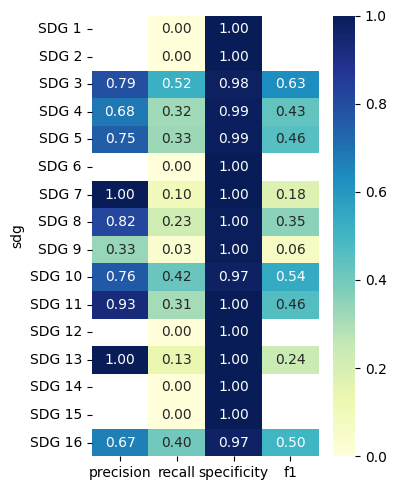

uoft_dict_approach


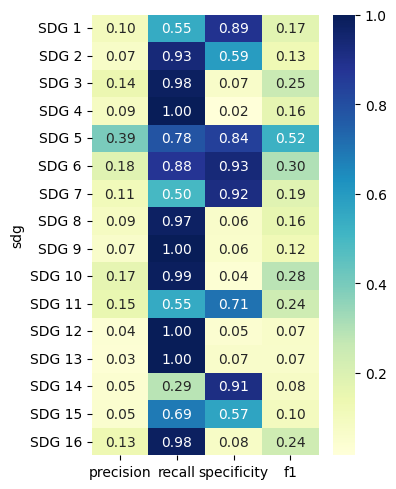

In [44]:
for model_name, group in relevant_data.groupby("model_name"):
    group["specificity"] = group["TN"]/ (group["TN"] + group["FP"])
    prf1 = group[["sdg", 'precision', 'recall', 'specificity', 'f1']].set_index("sdg").reindex(SDG_ORDER)
    print(model_name)
    plt.figure(figsize=(4,5))
    sns.heatmap(prf1, cmap='YlGnBu', annot=True, fmt='.2f')
    plt.tight_layout()
    plt.savefig(f"../data/presentation_figures/{model_name}_performance.png", dpi=300)
    plt.show()